In [1]:
from autograd import elementwise_grad, jacobian
import autograd.numpy as np


from autograd.scipy import stats as sps
import matplotlib.pyplot as plt

from IPython.display import display, Math, Latex


import matplotlib.pyplot as plt
from IPython.display import display, Math, Latex


# Data Processing

# ADVI

In [163]:
# our model


class ADVI:
    def __init__(self, model, inv_T, var_family="mean"):
        self.model = model
        self.inv_T = inv_T
        self.dim = self.model.dim
        self.var_family = var_family
        self.eta_len = self.model.eta_shape[0]*self.model.eta_shape[1]

        ## Compute Gradients  of log priors       
        self.grad_log_prior_theta = elementwise_grad(model._log_prior_theta)
        self.grad_log_prior_mu = elementwise_grad(model._log_prior_mu)
        self.grad_log_prior_sigma = elementwise_grad(model._log_prior_sigma)
        self.grad_log_likelihood = elementwise_grad(model._log_likelihood)
        #self.grad_log_joint = elementwise_grad(model.log_joint)  # θ -> ∇log p(x, θ)
        self.grad_inv_T = elementwise_grad(inv_T)  # ζ -> ∇T⁻¹(ζ)
        
        jacobian_det_inv_T = lambda zeta: np.linalg.det(jacobian(inv_T)(zeta) + +np.identity(self.eta_len)*1e-9) #to tackle rounding issues
        self.log_jac_inv_T = lambda zeta: np.log(np.abs(jacobian_det_inv_T(zeta)))  # ζ -> log|det J_{T⁻¹}(ζ)| 
        self.grad_log_jac_inv_T = elementwise_grad(self.log_jac_inv_T)  # ζ -> ∇log|det J_{T⁻¹}(ζ)|



        # To optimize
        self.mu = np.zeros(self.eta_len)
        if self.var_family == "mean":
            self.omega = np.zeros(self.eta_len)
        elif self.var_family == "full-rank":
            self.omega = np.identity(self.eta_len)
        else:
            raise Exception("Variational family must be mean or full-rank")

        self.history = {"mu": [], "omega": [], "elbo": []}


    def update_params(self, mu, rho_mu, nabla_mu, omega, rho_omega, nabla_omega):
        # print("nabla mu:", nabla_mu)
        # print("rho mu:", np.diag(rho_mu))
        self.mu = mu + np.diag(rho_mu) @ nabla_mu
        if self.var_family == "mean":  
            self.omega = omega + np.diag(rho_omega) @ nabla_omega
        elif self.var_family == "full-rank":
            self.omega = omega + np.tril(np.diag(rho_omega) @ nabla_omega)

        self.history["mu"].append(mu)
        self.history["omega"].append(omega)


    def _zeta(self, eta):
        # inverse transformation of the elliptical standardization
        if self.var_family == "mean":
            #return eta @ np.diag(np.exp(self.omega)) + self.mu
            return eta * np.exp(self.omega) + self.mu
        elif self.var_family == "full-rank":
            return eta @ self.omega + self.mu

    def _theta(self, zeta):
        # inverse of the transformation applied to change the domain of our family's parameters to real values
        return self.inv_T(zeta)
    

    def _nabla_mu_inside_expect(self, eta):
        zeta = self._zeta(eta)
        original_space = self._theta(zeta)
        
        theta, mu, sigma = self.model.params(original_space)
        grad_log_joint_eval = np.concatenate([self.grad_log_prior_theta(theta)[:, 0],
                            self.grad_log_prior_mu(mu).flatten() ,
                            self.grad_log_prior_sigma(sigma).flatten()]) + \
                            self.grad_log_likelihood(original_space)
        
        grad_inv_T_eval = self.grad_inv_T(zeta)
        grad_log_jac_inv_T_eval = self.grad_log_jac_inv_T(zeta) 
        return grad_log_joint_eval * grad_inv_T_eval + grad_log_jac_inv_T_eval


    def _nabla_omega_inside_expect(self, nabla_mu_eval, eta):
        if self.var_family == "mean":
            return nabla_mu_eval * eta * np.exp(self.omega) + 1
        if self.var_family == "full-rank":
            return nabla_mu_eval @ eta + np.linalg.inv(self.omega)

        


    def _gradients_approximate(self, M):
        # MC integration, we draw M samples from a standard multivariate Gaussian 
        nabla_mu = np.zeros(self.eta_len)
        if self.var_family == "mean":
            nabla_omega = np.zeros(self.eta_len)
        elif self.var_family == "full-rank":
            nabla_omega = np.zeros([self.eta_len, self.eta_len])
            

        for m in range(M):
            eta = np.random.normal(size=self.eta_len)
            nabla_mu_eval = self._nabla_mu_inside_expect(eta)
            #print("nabla mu :", nabla_mu_eval)
            nabla_mu += nabla_mu_eval
            nabla_omega += self._nabla_omega_inside_expect(nabla_mu_eval, eta)
        return nabla_mu / M, nabla_omega / M

    
    
    def _approximate_elbo(self, M):
        """Approximate the elbo for the current mu and omega values using MC integration (cf. equation 5)
        """
        elbo_left = 0
        for _ in range(M):
            eta = np.random.normal(size=self.eta_len)
            zeta = self._zeta(eta)
            original_space = self._theta(zeta)
            theta, mu, sigma = self.model.params(original_space)
            elbo_left += self.model.log_joint( theta, mu, sigma) + self.log_jac_inv_T(zeta)
        elbo_left /= M
        entropy = self.omega.sum()  # + constant = 0.5 * self.dim * (1 + np.log(2 * np.π))
        return elbo_left + entropy

    def run(self, learning_rate, M=10, epsilon=0.01, tau=1,  alpha=0.1, verbose=True):
        # Stochastic optimization
        def get_learning_rate(i, s, grad, tau, alpha):
            s = alpha * grad**2 + (1 - alpha) * s
            rho = learning_rate * (i ** (-0.5 + 1e-16)) / (tau + np.sqrt(s))
            return rho, s

        elbo_old = self._approximate_elbo(M)
        print("old ELBO :", elbo_old)
        
        delta_elbo = 2 * epsilon
        i = 1
        while np.abs(delta_elbo) > epsilon:  # Change using ELBO
            # Approximate gradients using MC integration
            
            nabla_mu, nabla_omega = self._gradients_approximate(M)

            # Calculate step size
            if i == 1:
                s_mu, s_omega = nabla_mu ** 2, nabla_omega ** 2
            rho_mu, s_mu = get_learning_rate(i, s_mu, nabla_mu, tau, alpha)
            rho_omega, s_omega = get_learning_rate(i, s_omega, nabla_omega, tau, alpha)

            # Update mu and omega
            self.update_params( self.mu,rho_mu, nabla_mu, self.omega, rho_omega, nabla_omega)


            print(i, self.mu)
            # Update elbo
            elbo = self._approximate_elbo(100)
            print("updated ELBO: ", elbo)
            self.history["elbo"].append(elbo)
            delta_elbo = elbo - elbo_old
            print("delta ELBO: ", delta_elbo)
            elbo_old = elbo

            if verbose and (i % 10 == 0):
                print(f"ELBO {elbo}, mu {self.mu}, omega {self.omega}")
            i += 1

# GMM

In [164]:
from scipy.stats import norm, dirichlet, lognorm, multivariate_normal, chi2
import autograd

In [165]:
class GMM:
    def __init__(self, X, num_components):
        self.x = X
        
        self.dim = self.x.shape[1]
        self.N = self.x.shape[0]
        self.num_components = num_components

        self.alpha0 = 1000
        self.vec_alpha0 = np.array([self.alpha0 for _ in range(self.num_components)])
        self.theta = dirichlet.rvs(self.vec_alpha0, 1).T

        self.mu = multivariate_normal.rvs(np.zeros(self.dim), np.ones(self.dim), size= self.num_components) # K*D
        self.mu_mean = np.zeros(self.dim)
        self.mu_std = np.ones(self.dim)


        self.sigma = np.array([lognorm.rvs(1, size=self.dim).tolist() for k in range(self.num_components)]) #K*D
        self.sigma_mean = np.zeros(self.dim)
        self.sigma_std = np.ones(self.dim)

        self.primitive_norm =  sps.norm.logpdf
        self.primitive_dirichlet =  sps.dirichlet.logpdf
        self.primitive_lognorm = sps.lognorm.logpdf
        self.primitive_norm_likelihood =  sps.norm.pdf

        self.eta_shape = (self.num_components, 2*self.dim+1)

    def params(self, eta):
        theta = np.array(eta[:self.num_components*1]).reshape(self.num_components, 1)
        mu = np.array(eta[self.num_components*1:self.num_components*(1+self.dim)]).reshape(self.num_components, self.dim)
        sigma = np.array(eta[self.num_components*(1+self.dim):self.num_components*(1+2*self.dim)]).reshape(self.num_components, self.dim)
        return theta, mu, sigma


    def _log_prior_theta(self, theta): # theta should be num_components*(2*dims+1)
        return  self.primitive_dirichlet(theta, self.vec_alpha0).sum()

    def _log_prior_mu(self, mu): # theta should be num_components*(2*dims+1)
        mu_log_prior = self.primitive_norm(mu, self.mu_mean, self.mu_std).sum() #_multi
        return mu_log_prior
    
    def _log_prior_sigma(self, sigma): # theta should be num_components*(2*dims+1)
        sigma_log_prior = np.array([self.primitive_lognorm(1,sigma[k], self.sigma_mean, self.sigma_std) for k in range(self.num_components)]).sum()
        return sigma_log_prior


# Problem here
    def _log_likelihood(self, eta):
        theta, mu, sigma = self.params(eta)
        log_likelihood = np.log(
            np.array([theta[k]*self.primitive_norm_likelihood(self.x, mu[k], sigma[k]) for k in range(self.num_components)]).sum()).sum()
        return log_likelihood



    def log_joint(self, theta, mu, sigma):
        log_joint = self._log_likelihood(  np.concatenate([theta, mu, sigma], axis=1).T.flatten() )+ self._log_prior_theta(theta)+ self._log_prior_mu(mu)+ self._log_prior_sigma(sigma)
        return log_joint

In [185]:
from sklearn import cluster, datasets, mixture

blobs = datasets.make_blobs(n_samples=500,n_features=4, random_state=42)[0]

In [186]:
num_components =6
x_dim =  blobs.shape[1]
model = GMM(blobs, num_components)



# def softmax(x):
#     exp_x = [np.exp(i) for i in x]  # Subtracting the maximum value for numerical stability
#     return exp_x / np.sum(exp_x)

# def exponential(x):
#     exp_x = [np.exp(i) for i in x]  # Subtracting the maximum value for numerical stability
#     return exp_x 

# def inv_T(zeta):
#     return np.array([*softmax(zeta._value[:num_components]), *exponential(zeta[num_components:])], dtype=float)
# inv_T_vec = np.vectorize(inv_T, signature='(n)->(n)')

def softmax(x):
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x)

def exponential(x):
    exp_x = np.exp(x)
    return exp_x 


# def inv_T(zeta):
#     if type(zeta) == np.ndarray:
#         return np.array([*softmax(zeta[:num_components]), *exponential(zeta[num_components:])], dtype=float)
#     else:
#         return np.array([*softmax(zeta._value[:num_components]), *exponential(zeta._value[num_components:])], dtype=float)

def inv_T(zeta):

    return np.array([*softmax(zeta[:num_components]), *exponential(zeta[num_components:])], dtype=float)



In [187]:
np.seterr(over='raise', divide='raise', invalid = 'raise')

{'divide': 'raise', 'over': 'raise', 'under': 'ignore', 'invalid': 'raise'}

In [188]:
advi = ADVI(model, inv_T, var_family="mean")
advi.run(learning_rate=0.01)
print()
print("Theta Pred mean", inv_T(advi.mu))
print("Theta Pred std", inv_T(advi.omega))

old ELBO : -2694.5281000329314
1 [ 0.00287471 -0.00080305  0.00117217  0.00261061 -0.00207239 -0.00350983
 -0.00883952 -0.00648827 -0.00829582 -0.00603728 -0.00329883 -0.00141518
 -0.00906481 -0.00833874 -0.00116599 -0.00847552 -0.00846468 -0.00886487
 -0.00832427 -0.00673436 -0.0017813  -0.00646604 -0.00902629 -0.00647002
 -0.00409703 -0.00910578 -0.00853086 -0.00958821 -0.0050293  -0.00528405
  0.00499179  0.00501022  0.00501034  0.00498356  0.00496589  0.00501913
  0.0050124   0.0049509   0.00499266  0.00501901  0.00501641  0.00496912
  0.0050029   0.00501326  0.00501849  0.00497532  0.00498976  0.00502699
  0.00501338  0.0049541   0.00496077  0.00499037  0.00500678  0.00496202]
updated ELBO:  -2435.601861372241
delta ELBO:  258.9262386606906
2 [ 3.66389785e-03 -3.31923803e-03  2.98172562e-03  9.33757177e-04
  7.67086420e-05 -4.01394453e-03 -1.10381436e-02 -2.11310884e-02
 -8.65071479e-03 -1.20988473e-02 -9.25030770e-03 -1.60747203e-02
 -1.14330508e-02 -1.34580561e-02 -4.29590440e-0

KeyboardInterrupt: 

# PPCA

In [ ]:
class PPCA:
    """
        y ~ Normal(X⋅beta, sigma)
        beta_k ~ Normal(beta_mu, beta_std)
        sigma ~ Gamma(sigma_shape, sigma_scale)
    """
    def __init__(self, X, y, prior_beta_mu, prior_beta_std, prior_sigma_shape, prior_sigma_scale):
        self.x = X
        self.y = y

        self.dim = self.x.shape[1] + 2  # (intercept (beta0), betas, sigma)  
        self.N = self.x.shape[0]
        
        # Prior hyperparameters
        # self.betas_mu = prior_beta_mu * np.ones(self.dim - 1)
        # self.betas_std = prior_beta_std * np.ones(self.dim - 1)
        self.betas_mu = np.full(self.dim - 1, prior_beta_mu)
        self.betas_std = np.full(self.dim - 1, prior_beta_std)
        self.sigma_shape = prior_sigma_shape
        self.sigma_scale = prior_sigma_scale

    def params(self, theta):
        # [TODO] Change it into a wrapper to convert theta into (betas, sigma) 
        assert len(theta) == self.dim
        return theta[:2], theta[2]
    
    def _log_priors(self, theta):
        betas, sigma = self.params(theta)
        betas_log_prior = sps.norm.logpdf(betas, self.betas_mu, self.betas_std).sum()
        sigma_log_prior = sps.gamma.logpdf(sigma / self.sigma_scale, self.sigma_shape) - np.log(self.sigma_scale)
        return betas_log_prior + sigma_log_prior

    def _log_likelihood(self, theta):
        betas, sigma = self.params(theta)
        x_ones = np.hstack([np.ones((self.N, 1)), self.x])
        y_hat = x_ones @ betas
        return sps.norm.logpdf(self.y, y_hat, sigma).sum()

    def log_joint(self, theta):
        return self._log_priors(theta) + self._log_likelihood(theta)

    def describe(self):
        display(Math(fr"""
            y_i \sim \mathcal{{N}}(\mathbf{{\beta}} \mathbf{{X}}_i, \sigma) \\
            \beta_k \sim \mathcal{{N}}(m, s^2) \\
            \sigma \sim \mathcal{{G}}(\alpha, \lambda)
            """))

# Testing

In [ ]:
from sklearn import cluster, datasets, mixture

noisy_moons = datasets.make_moons(n_samples=500, noise=0.05, random_state=42)

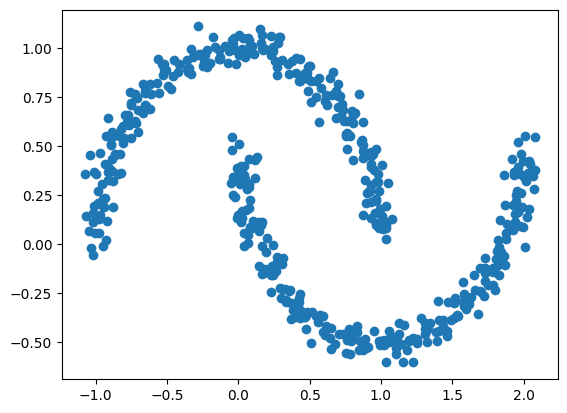

In [ ]:
plt.scatter(noisy_moons[0][:, 0], noisy_moons[0][:, 1])

In [ ]:
varied = datasets.make_blobs(
    n_samples=500, cluster_std=[1.0, 2.5, 0.5], random_state=42
)

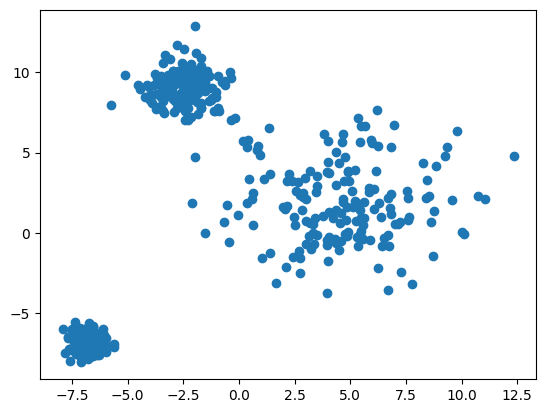

In [ ]:
plt.scatter(varied[0][:, 0], varied[0][:, 1])

In [ ]:


N, d = 1000, 1
betas_true = np.array([5, -3])
sigma_true = 2.5

X = np.random.normal(0, 2, (N, d))
X_ones = np.hstack([np.ones((N, 1)), X])
y = X_ones @ betas_true + np.random.normal(0, sigma_true, N)

model = LinearModel(X, y, 0, 10, 1, 2)
model.describe()


def inv_T(zeta):
    return np.array([*zeta[:-1], np.exp(zeta[-1])], dtype=float)
inv_T_vec = np.vectorize(inv_T, signature='(n)->(n)')

advi = ADVI(model, inv_T, var_family="full-rank")
advi.run(learning_rate=0.5)
print()
print("Theta True", [*betas_true, sigma_true])
print("Theta Pred mean", inv_T(advi.mu))
print("Theta Pred std", inv_T(advi.omega))
# %%

<IPython.core.display.Math object>

1 [ 0.49999615 -0.49999817  0.49999967]
2 [ 0.51912557 -0.50183944  0.51391493]
3 [ 0.52272978 -0.50539565  0.51724976]
4 [ 0.52689239 -0.50815444  0.52077332]
5 [ 0.53339259 -0.51027841  0.52584077]
6 [ 0.54060312 -0.51208176  0.53149369]
7 [ 0.54479606 -0.5137261   0.53522808]
8 [ 0.55182943 -0.51585706  0.54056679]
9 [ 0.55594733 -0.51924306  0.54400385]
10 [ 0.55761373 -0.52161238  0.54612476]
ELBO -16929.694225753043, mu [ 0.55761373 -0.52161238  0.54612476], omega [[-0.45922569  0.          0.        ]
 [-1.45922569 -0.45921661  0.        ]
 [-1.45922569 -1.45921661 -0.45922092]]
11 [ 0.56175406 -0.52413872  0.54938655]
12 [ 0.56877433 -0.52600816  0.5554685 ]
13 [ 0.5730303  -0.52828063  0.55886448]
14 [ 0.5773666  -0.53075866  0.56256738]
15 [ 0.58578824 -0.53219933  0.56929766]
16 [ 0.58945236 -0.53483856  0.57223564]
17 [ 0.59264869 -0.53726407  0.57500131]
18 [ 0.60255073 -0.53701703  0.58463433]
19 [ 0.60820413 -0.53989279  0.58875853]
20 [ 0.61370477 -0.54251293  0.5928350

KeyboardInterrupt: 

In [ ]:
N, d = 1000, 1
betas_true = np.array([5, -3])
sigma_true = 2.5

X = np.random.normal(0, 2, (N, d))
X_ones = np.hstack([np.ones((N, 1)), X])
y = X_ones @ betas_true + np.random.normal(0, sigma_true, N)

model = LinearModel(X, y, 0, 10, 1, 2)
model.describe()


def inv_T(zeta):
    return np.array([*zeta[:-1], np.exp(zeta[-1])], dtype=float)
inv_T_vec = np.vectorize(inv_T, signature='(n)->(n)')

advi = ADVI(model, inv_T, var_family="mean")
advi.run(learning_rate=0.1, epsilon=0.001)
print()
print("Theta True", [*betas_true, sigma_true])
print("Theta Pred mean", inv_T(advi.mu))
print("Theta Pred std", inv_T(advi.omega))

<IPython.core.display.Math object>

1 [ 0.09999724 -0.09999905  0.09999985]
2 [ 0.13471745 -0.12658182  0.12367448]
3 [ 0.23491673 -0.21386708  0.20267629]
4 [ 0.25193495 -0.23743239  0.22417439]
5 [ 0.26019705 -0.2457514   0.23163116]
6 [ 0.2649108  -0.24914519  0.23467611]
7 [ 0.28139559 -0.26351945  0.2491965 ]
8 [ 0.2928033  -0.27233859  0.25701361]
9 [ 0.30484065 -0.28071765  0.26505406]
10 [ 0.31042728 -0.28712757  0.27070481]
ELBO -65778.44338889755, mu [ 0.31042728 -0.28712757  0.27070481], omega [-0.18930281 -0.13774233 -0.24009798]
11 [ 0.31610318 -0.29305121  0.27597285]
12 [ 0.32788182 -0.30273819  0.28503115]
13 [ 0.33789575 -0.31616761  0.29793079]
14 [ 0.34065917 -0.31925297  0.30074009]
15 [ 0.34768698 -0.32965732  0.30965142]
16 [ 0.35695386 -0.33849483  0.31712518]
17 [ 0.36255704 -0.34560899  0.32367984]
18 [ 0.38124515 -0.36279771  0.33765486]
19 [ 0.39716711 -0.38160604  0.35571913]
20 [ 0.44135798 -0.41217654  0.38292616]
ELBO -40399.7912988614, mu [ 0.44135798 -0.41217654  0.38292616], omega [-0.15